In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import random
import PIL.ImageOps    


from torch.utils.data import DataLoader, Dataset
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils

In [3]:
import torchvision.transforms.functional as functional
import os
import torchvision.transforms as T
# from torchvision.transforms import functional as F
import math


In [4]:
class FixedHeightResize:
    def __init__(self, size):
        self.size = size
        
    def __call__(self, img):
        w, h = img.size
        aspect_ratio = float(h) / float(w)
        
        new_w = math.ceil(self.size / aspect_ratio)
        return F.resize(img, (self.size, new_w))

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
#         self.transform=transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
        self.transform = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        # FixedHeightResize(190),
        transforms.Resize((256,256)),
         transforms.ToTensor()
                                    
    ]
)
        self.image_pairs = self.load_image_pairs()

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        image1_path, image2_path, label = self.image_pairs[idx]
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        
    
        # Convert the tensor to a PIL image
        # image1 = functional.to_pil_image(image1)
        # image2 = functional.to_pil_image(image2)
        
        image1 = self.transform(image1)
        image2 = self.transform(image2)
        # image1 = torch.clamp(image1, 0, 1)
        # image2 = torch.clamp(image2, 0, 1)
        return image1, image2, label

    def load_image_pairs(self):
        image_pairs = []
        # Assume the directory structure is as follows:
        # root_dir
        # ├── similar
        # │   ├── similar_image1.jpg
        # │   ├── similar_image2.jpg
        # │   └── ...
        # └── dissimilar
        #     ├── dissimilar_image1.jpg
        #     ├── dissimilar_image2.jpg
        #     └── ...
        similar_dir = os.path.join(self.root_dir, "similar_all_images")
        dissimilar_dir = os.path.join(self.root_dir, "dissimilar_all_images")

        # Load similar image pairs with label 1
        similar_images = os.listdir(similar_dir)
        for i in range(len(similar_images) // 2):
            image1_path = os.path.join(similar_dir, f"similar_{i}_first.jpg")
            image2_path = os.path.join(similar_dir, f"similar_{i}_second.jpg")
            image_pairs.append((image1_path, image2_path, 0))

        # Load dissimilar image pairs with label 0
        dissimilar_images = os.listdir(dissimilar_dir)
        for i in range(len(dissimilar_images) // 2):
            image1_path = os.path.join(dissimilar_dir, f"dissimilar_{i}_first.jpg")
            image2_path = os.path.join(dissimilar_dir, f"dissimilar_{i}_second.jpg")
            image_pairs.append((image1_path, image2_path, 1))

        return image_pairs


In [ ]:
dataset = ImagePairDataset(r"/home/niq/hcsr2001/data/image_similarity")


In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
example_batch = next(iter(train_loader))

In [ ]:
example_batch[0].shape,example_batch[1].shape,example_batch[2].shape

In [ ]:
import matplotlib.pyplot as plt

In [12]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 32, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

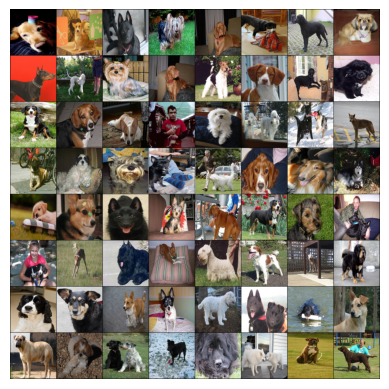

In [13]:
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))

In [14]:
example_batch[2]

tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0])

In [15]:
example_batch[1].shape

torch.Size([32, 3, 256, 256])

In [16]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        # self.cnn1 = nn.Sequential(
        #     nn.Conv2d(3, 256, kernel_size=11,stride=4),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(3, stride=2),
            
        #     nn.Conv2d(256, 256, kernel_size=5, stride=1),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(2, stride=2),

        #     nn.Conv2d(256, 384, kernel_size=3,stride=1),
        #     nn.ReLU(inplace=True)
        # )
        
        self.cnn1=nn.Conv2d(3, 256, kernel_size=11,stride=4)
        self.relu = nn.ReLU()
        self.maxpool1=nn.MaxPool2d(3, stride=2)
        self.cnn2=nn.Conv2d(256, 256, kernel_size=5,stride=1)
        self.maxpool2=nn.MaxPool2d(2, stride=2)
        self.cnn3=nn.Conv2d(256, 384, kernel_size=3,stride=1)
        self.fc1 =nn.Linear(46464, 1024)
        self.fc2=nn.Linear(1024, 256)
        self.fc3=nn.Linear(256, 1)
        # Setting up the Fully Connected Layers
        # self.fc1 = nn.Sequential(
        #     nn.Linear(384, 1024),
        #     nn.ReLU(inplace=True),
            
        #     nn.Linear(1024, 32*46464),
        #     nn.ReLU(inplace=True),
            
        #     nn.Linear(32*46464,1)
        # )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        # output = self.cnn1(x)
        # print(output.view(output.size()[0], -1).shape)
        # output = output.view(output.size()[0], -1)
        # output = self.fc1(output)
        # print(x.shape)
        output= self.cnn1(x)
        # print(output.shape)
        output=self.relu(output)
        # print(output.shape)
        output=self.maxpool1(output)
        # print(output.shape)
        output= self.cnn2(output)
        # print(output.shape)
        output=self.relu(output)
        # print(output.shape)
        output=self.maxpool2(output)
        # print(output.shape)
        output= self.cnn3(output)
        output=self.relu(output)
        # print(output.shape)
        output=output.view(output.size()[0], -1)
        # print(output.shape)
        output=self.fc1(output)
        # print(output.shape)
        output=self.fc2(output)
        # print(output.shape)
        output=self.fc3(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [17]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [18]:
example_batch[0].shape

torch.Size([32, 3, 256, 256])

In [19]:
# train_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=8,
#                         batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 1.619093418121338



Epoch number 0
 Current loss 1.0774962902069092

Epoch number 1
 Current loss 1.7849295139312744

Epoch number 1
 Current loss 1.3328968286514282

Epoch number 2
 Current loss 1.3782997131347656

Epoch number 2
 Current loss 1.5084214210510254

Epoch number 3
 Current loss 1.4599947929382324

Epoch number 3
 Current loss 1.3879544734954834

Epoch number 4
 Current loss 1.5093083381652832

Epoch number 4
 Current loss 1.2645900249481201

Epoch number 5
 Current loss 1.294891595840454

Epoch number 5
 Current loss 1.3015356063842773

Epoch number 6
 Current loss 1.4716356992721558

Epoch number 6
 Current loss 1.3314270973205566

Epoch number 7
 Current loss 1.2187273502349854

Epoch number 7
 Current loss 1.5677021741867065

Epoch number 8
 Current loss 1.3630397319793701

Epoch number 8
 Current loss 1.8554917573928833

Epoch number 9
 Current loss 1.4668326377868652

Epoch number 9
 Current loss 1.2339060306549072

Epoch number 10
 Current loss 1.3608249425888062

Epoch number 10
 Cur

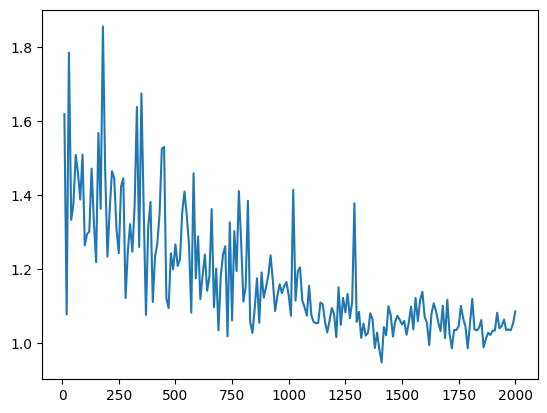

In [20]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_loader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [23]:
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False)

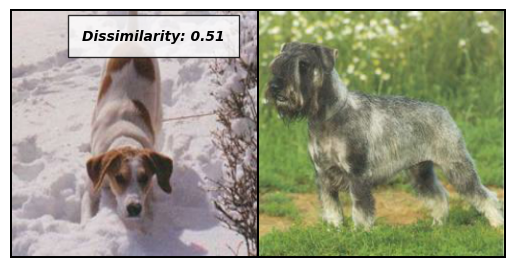

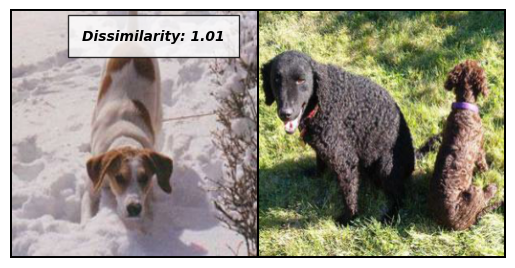

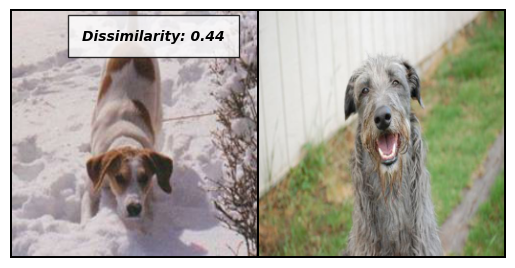

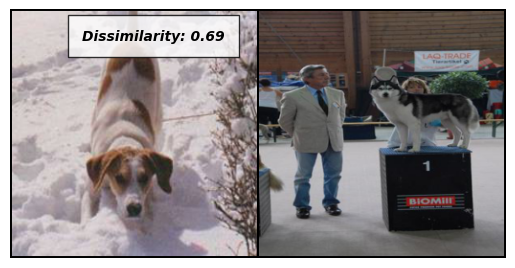

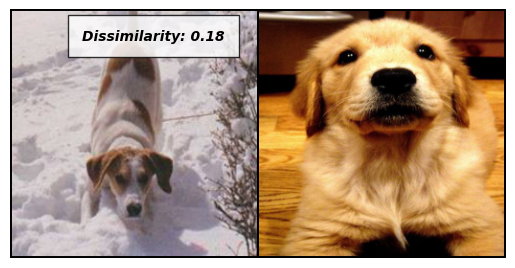

In [24]:
# Locate the test dataset and load it into the SiameseNetworkDataset
# folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transformation)
# test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_loader_one)
x0, _, _ = next(dataiter)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [25]:
x0.shape,x1.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [26]:
output1.shape

torch.Size([1, 1])

In [27]:
output2.shape

torch.Size([1, 1])

In [22]:
euclidean_distance

tensor([1.0048, 1.1675, 1.0005, 0.9073, 0.9950, 0.7151, 0.8667, 1.0763, 0.8447,
        0.9946, 0.8461, 0.9447, 0.8733, 0.9992, 0.7658, 1.0175, 0.9973, 0.7065,
        1.0681, 0.6810, 0.9993, 0.9389, 0.8176, 1.1098, 1.2094, 1.0063, 1.0142,
        0.8423, 0.8159, 0.8302, 0.8969, 0.6374], device='cuda:0',
       grad_fn=<NormBackward1>)

In [ ]:
(32*46464)/1

In [ ]:
384*1024